In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = True)


In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)



# reflect the tables


2023-01-11 21:44:42,767 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2023-01-11 21:44:42,768 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-01-11 21:44:42,769 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("measurement")
2023-01-11 21:44:42,769 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-01-11 21:44:42,771 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2023-01-11 21:44:42,772 INFO sqlalchemy.engine.Engine [raw sql] ('measurement',)
2023-01-11 21:44:42,773 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("measurement")
2023-01-11 21:44:42,773 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-01-11 21:44:42,773 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("measurement")
2023-01-11 21:44:42,773 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-01-11 21:44:42,774 INFO sqlalchemy.engine.Engine SELECT sql

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date=session.query(Measure.date).order_by(Measure.date.desc()).first()
latest_date


2023-01-11 21:44:42,852 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-01-11 21:44:42,854 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2023-01-11 21:44:42,854 INFO sqlalchemy.engine.Engine [generated in 0.00042s] (1, 0)


('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago
# Perform a query to retrieve the data and precipitation scores
result = session.query(Measure.date,Measure.prcp).filter(Measure.date >= dt.date(2016,8,23)).filter(Measure.date <= dt.date(2017,8,23)).all()
result
# Save the query results as a Pandas DataFrame and set the index to the date column
result_df=pd.DataFrame(result).set_index('date')
result_df.head()

# Sort the dataframe by date
result_df_sort = result_df.sort_values('date')
result_df_sort.head()






2023-01-11 21:44:42,869 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2023-01-11 21:44:42,869 INFO sqlalchemy.engine.Engine [generated in 0.00062s] ('2016-08-23', '2017-08-23')


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


<AxesSubplot:title={'center':'Last 12 months precipitation'}, xlabel='date', ylabel='Inches'>

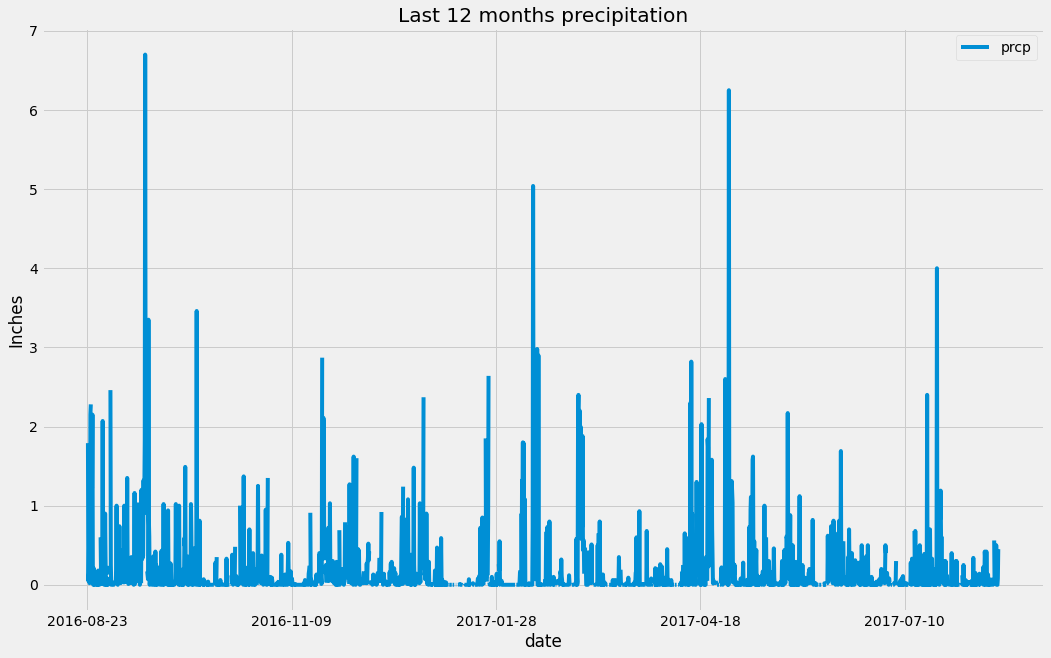

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
result_df_sort.plot(title='Last 12 months precipitation', ylabel='Inches', figsize=(16,10))

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
result_df_sort.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Measure).group_by(Measure.station).count()
num_stations

2023-01-11 21:44:43,052 INFO sqlalchemy.engine.Engine SELECT count(*) AS count_1 
FROM (SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement GROUP BY measurement.station) AS anon_1
2023-01-11 21:44:43,053 INFO sqlalchemy.engine.Engine [generated in 0.00083s] ()


9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations= session.query(Measure.station, func.count(Measure.station)).group_by(Measure.station).order_by(func.count(Measure.station).desc()).all()
active_stations


2023-01-11 21:44:43,068 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC
2023-01-11 21:44:43,068 INFO sqlalchemy.engine.Engine [generated in 0.00081s] ()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
most_active = active_stations[0][0]
most_active

'USC00519281'

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measure.station,func.max(Measure.tobs),func.min(Measure.tobs),func.avg(Measure.tobs)).filter(Measure.station == most_active).all()

2023-01-11 21:44:43,093 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, max(measurement.tobs) AS max_1, min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = ?
2023-01-11 21:44:43,095 INFO sqlalchemy.engine.Engine [generated in 0.00198s] ('USC00519281',)


[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date1=session.query(Measure.date).filter(Measure.station==most_active).order_by(Measure.date.desc()).first()
latest_date1



2023-01-11 21:44:43,105 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement 
WHERE measurement.station = ? ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2023-01-11 21:44:43,106 INFO sqlalchemy.engine.Engine [generated in 0.00060s] ('USC00519281', 1, 0)


('2017-08-18',)

In [18]:
year_ago = dt.date(2017,8,18) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 18)

In [19]:
temp_data=session.query(Measure.date,Measure.tobs).filter(Measure.date >= dt.date(2016,8,18)).filter(Measure.date <= dt.date(2017,8,18)).all()
temp_data

2023-01-11 21:44:43,121 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date >= ? AND measurement.date <= ?
2023-01-11 21:44:43,121 INFO sqlalchemy.engine.Engine [generated in 0.00062s] ('2016-08-18', '2017-08-18')


[('2016-08-18', 80.0),
 ('2016-08-19', 77.0),
 ('2016-08-20', 80.0),
 ('2016-08-21', 76.0),
 ('2016-08-22', 77.0),
 ('2016-08-23', 81.0),
 ('2016-08-24', 79.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 79.0),
 ('2016-08-27', 77.0),
 ('2016-08-28', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-31', 80.0),
 ('2016-09-01', 81.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 79.0),
 ('2016-09-04', 75.0),
 ('2016-09-05', 79.0),
 ('2016-09-06', 76.0),
 ('2016-09-07', 76.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 78.0),
 ('2016-09-11', 76.0),
 ('2016-09-12', 78.0),
 ('2016-09-13', 78.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 80.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 81.0),
 ('2016-09-19', 77.0),
 ('2016-09-20', 77.0),
 ('2016-09-21', 78.0),
 ('2016-09-22', 76.0),
 ('2016-09-23', 82.0),
 ('2016-09-24', 81.0),
 ('2016-09-25', 78.0),
 ('2016-09-26', 80.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 79.0),
 ('2016-09-29', 80.0),
 ('2016-09-

In [20]:
temp_df=pd.DataFrame(temp_data).set_index('date').sort_values('date')
temp_df

,tobs
date,
2016-08-18,80.0
2016-08-18,81.0
2016-08-18,80.0
2016-08-18,79.0
2016-08-18,73.0
...,...
2017-08-17,83.0
2017-08-18,80.0
2017-08-18,79.0


<AxesSubplot:title={'center':'Most Active Station Temperature for last 12 months'}, ylabel='Frequency'>

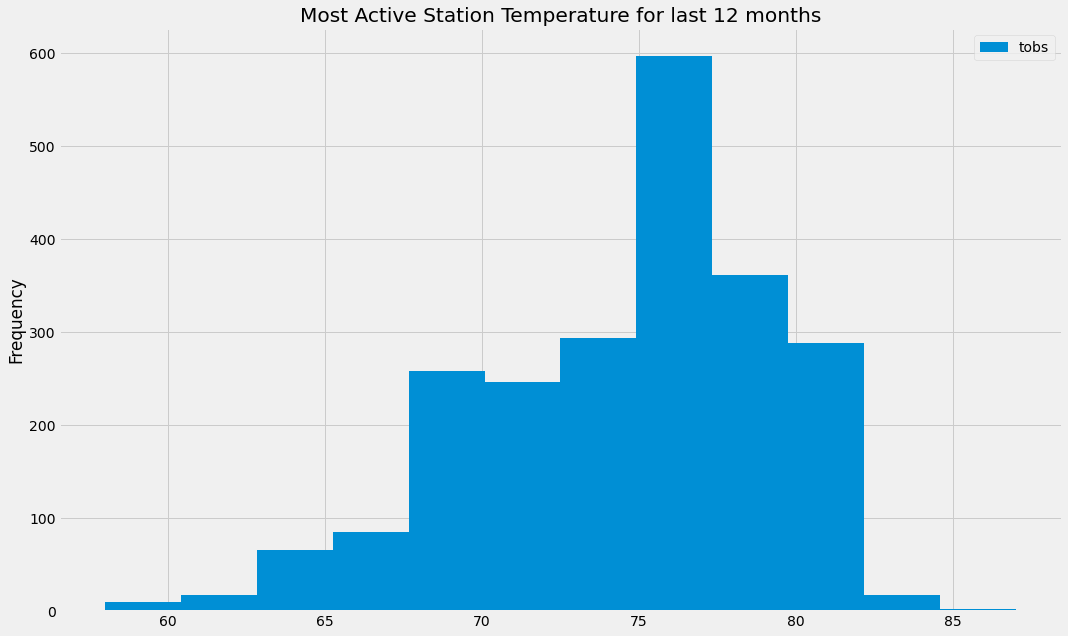

In [28]:
temp_df.plot(kind='hist',title=f'Most Active Station Temperature for last 12 months', xlabel='Temperature', bins=12, figsize=(16,10))



# Close session

In [25]:
# Close Session
session.close()